# Analysis of Image to Image GANs

In [1]:
from utils import *
from fid import FID

/fs/junkfood/ssaxena1/miniconda3/envs/gan/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
real_path = "Pix2Pix/figures/facades_old/202/training/full"
gen_path = "Pix2Pix/figures/facades_old/202/training/gen"
i, j = get_images(real_path, gen_path)

fid = FID()
print(fid.find_fid(i, j))

304.8691472840694


## Training and Analyzing Pix2Pix

The code below trains and analyzes the Pix2Pix model on a given dataset. 

You can provide your own arguments to train this model by altering the d_params dictionary. These are the arguments I have set in the code block below:

* dset - Location of the dataset within the logging directory
* batch_size - Size of batch for training
* n_batch_per_epoch - Number of batches in one epoch
* model_name - Name/Location of the model within the logging directory
* epoch - Number of epochs in one saving/analyzing iteration
* do_plot - Prints model summary and plots model architecture
* image_data_format - channels_last for tensorflow backend and channels_first for theano backend
* img_dim - Dimension of the Square Image
* patch_size - Patch Size for the discriminator
* logging_dir - The directory where everything is stored (models, logs, data, figures)
* save_latest - Saves only the latest model (space efficient)
* load_model - Location of saved models or None
* load_epoch - Epoch of saved models or latest or None
* base_epoch - Base epoch for all stats and graphs (default is 0)

To analyze this model while its training, add the following arguments to d_params"

* analyze - method of analysis
* analyze_batch - batch of images to analyze

In [3]:
import os
import argparse
import sys

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras.backend as K
K.set_image_data_format("channels_last")

sys.path.append("Pix2Pix/src/model/")
sys.path.append("Pix2Pix/src/utils/")
import train

d_params = {"dset": "facades",
            "generator": "upsampling",
            "batch_size": 4,
            "n_batch_per_epoch": 100,
            "nb_epoch": 400,
            "model_name": "facades",
            "epoch": 1,
            "nb_classes": 2,
            "do_plot": False,
            "image_data_format": "channels_last",
            "bn_mode": 2,
            "img_dim": 256,
            "use_label_smoothing": False,
            "label_flipping": 0,
            "patch_size": (64, 64),
            "use_mbd": False,
            "logging_dir": "Pix2Pix",
            "save_latest": True,
            "load_model": "facades_old",
            "load_epoch": "latest",
            "base_epoch": 200,
            "analyze": fid,
            "analyze_batch": 5
            }

analysis = train.train(**d_params)

Start training
396/400 [============================>.] - ETA: 8s - D logloss: 0.6939 - G tot: 4.0515 - G L1: 0.3374 - G logloss: 0.6771 
Epoch 201/400, Time: 886.7542498111725
Custom Analysis: Training - 268 Validation - 327
 36/400 [=>............................] - ETA: 12:04 - D logloss: 0.6925 - G tot: 4.0662 - G L1: 0.3385 - G logloss: 0.6812

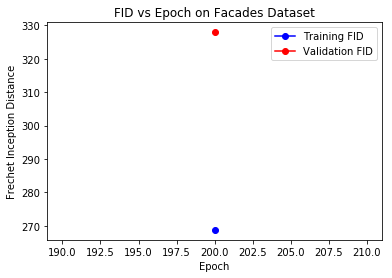

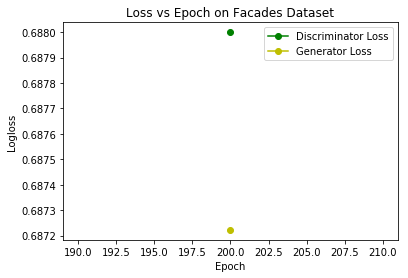

In [9]:
from matplotlib import pyplot as plt

x = [k for k in analysis["custom"]]
y_train = [analysis["custom"][k][0] for k in analysis["custom"]]
y_val = [analysis["custom"][k][1] for k in analysis["custom"]]

plt.plot(x, y_train, "bo-", label="Training FID")
plt.plot(x, y_val, "ro-", label="Validation FID")
plt.xlabel("Epoch")
plt.ylabel("Frechet Inception Distance")
plt.title("FID vs Epoch on Facades Dataset")
plt.legend()
plt.savefig("Pix2Pix/figures/facades/fid.png")
plt.show()

x = [k for k in analysis["disc_loss"]]
y = [analysis["disc_loss"][k] for k in analysis["disc_loss"]]
plt.plot(x, y, "go-", label="Discriminator Loss")

x = [k for k in analysis["gen_loss"]]
y = [analysis["gen_loss"][k] for k in analysis["gen_loss"]]

plt.plot(x, y, "yo-", label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Logloss")
plt.title("Loss vs Epoch on Facades Dataset")
plt.legend()
plt.savefig("Pix2Pix/figures/facades/loss.png")
plt.show()